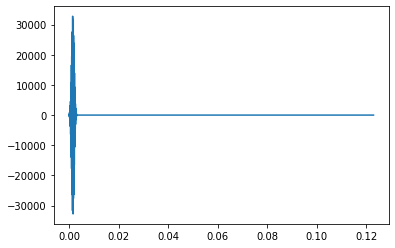

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
from time import time
from scipy.io.wavfile import write
from scipy.fft import fft, ifft, fftshift, ifftshift


# we prepare the audio pulse as numpy array according to the user desires

pulse_duration= 0.003
echo_recording_duration=0.08+0.04
frequency = 8000 # above human speech
gaussian_envelope=True
broadcast_sample_rate=44100
sigma_duration_ratio = 5

recording_sample_rate=44100


envelope_std = pulse_duration/sigma_duration_ratio


t = np.linspace(0, pulse_duration,
        int(pulse_duration*broadcast_sample_rate), False)
note = np.sin( 2*np.pi*frequency*t )
# if a gaussian envelope is desired, it is applied
if gaussian_envelope==True:
    def gaussian(x, mu, stdv):
        return np.exp(-0.5*(x - mu)**2 / stdv**2)/(np.sqrt(2.0*np.pi)*stdv)
    gaussian_f = gaussian(t, mu=pulse_duration/2.0, stdv=envelope_std)
    note = note*gaussian_f

# Ensure that highest value is in 16-bit range
audio = np.zeros(int((echo_recording_duration+pulse_duration)*broadcast_sample_rate), dtype=np.float64)
audio[:len(t)] = (note / np.max(np.abs(note)))*(2**15-1)
# Convert to 16-bit data
audio = audio.astype(np.int16)

t = np.linspace(0, pulse_duration+echo_recording_duration,
        int((pulse_duration+echo_recording_duration)*broadcast_sample_rate), False)
# show the audio pulse
plt.plot(t, audio)
plt.show()

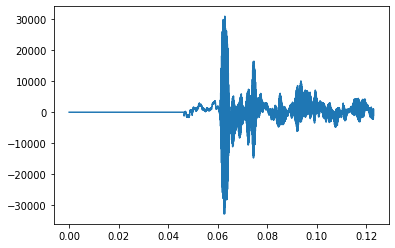

In [38]:
recording = sd.playrec(audio, recording_sample_rate, channels=1)

sd.wait()
middle_t=time()

# save recording
write(f"./Echo_.wav", 
          recording_sample_rate, recording)  # Save as WAV file

plt.plot(t, recording)
plt.show()
#while((time()-begin_t)<self.pulse_duration): # grab all the possible images


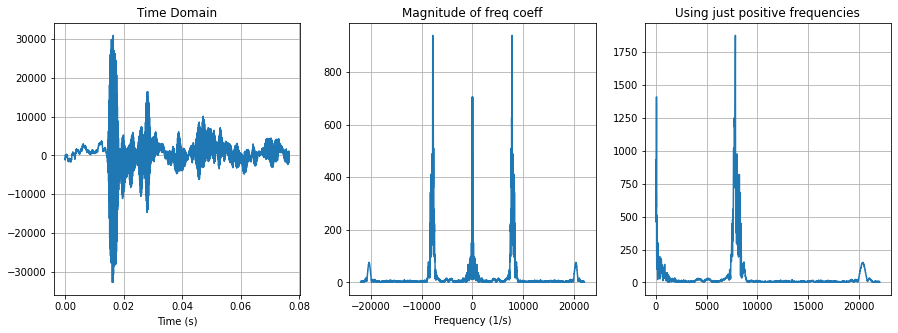

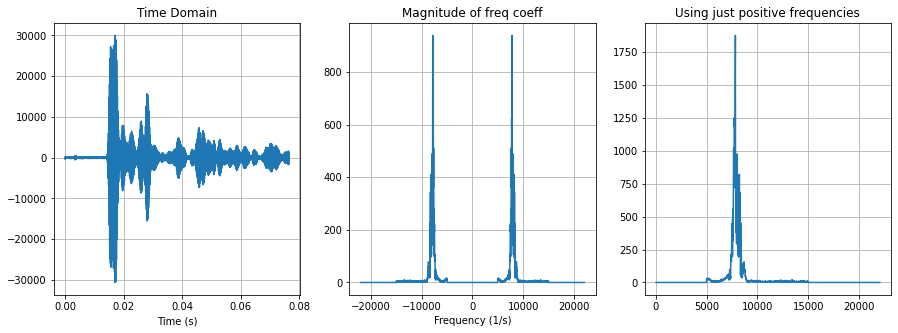

In [39]:
lower_freq_1 = 0
upper_freq_1 = 5000

lower_freq_2 = 15000
upper_freq_2 = 0.5*recording_sample_rate

# postprocess sound
# erase first zeros
difs = np.abs(recording[1:]-recording[:-1])
valid =  recording[np.argwhere(difs!=0)[0,0]:,0]
valid_times=t[:len(valid)]

# filtro pasa altos a 15 kHz
sample_rate=recording_sample_rate # discrete samples of the underlying function per second

# number of total signal points
N = len(valid)

# sample spacing is sample_rate smaples per second-> time between samples is:
T = 1.0 / sample_rate

#times = np.linspace(0.0, N*T, N)
#print(times, valid_times)

samplesFourierCoefs = fft(valid.astype(np.float64), N)
# frecs = np.concatenate((np.linspace(0, 1.0/(2.0*T), N//2), np.linspace(-1.0/(2.0*T), 0, N//2))) # before the shifting for plotting
frecs = np.linspace(-1.0/(2.0*T), 1.0/(2.0*T), N) # this is after applying the shift for ploting
samplesFourierCoefs = fftshift(samplesFourierCoefs)

def plot_fourier1D(times, frecs, samples, fourier_coefs):
    fig, axes = plt.subplots(1, 3, figsize=(15,5))
    axes[0].plot(times, samples)
    axes[0].set_title("Time Domain")
    axes[0].set_xlabel("Time (s)")
    axes[0].grid()

    axes[1].plot(frecs, 1/N*np.abs(fourier_coefs))
    axes[1].set_title("Magnitude of freq coeff")
    axes[1].set_xlabel("Frequency (1/s)")
    axes[1].grid()

    axes[2].plot(frecs[N//2:], 2/N*np.abs(fourier_coefs)[N//2:])
    axes[2].set_title("Using just positive frequencies")
    axes[2].grid()

    plt.show()

plot_fourier1D(valid_times, frecs, valid, samplesFourierCoefs)

# apply filtering
samplesFourierCoefs[ (np.abs(frecs)<=upper_freq_1) & (np.abs(frecs)>=lower_freq_1) ]=0
samplesFourierCoefs[ (np.abs(frecs)<=upper_freq_2) & (np.abs(frecs)>=lower_freq_2) ]=0

filtered_sound = ifft(ifftshift(samplesFourierCoefs)).real

plot_fourier1D(valid_times, frecs, filtered_sound, samplesFourierCoefs)